# PixelCNN: A Generative Model
PixelCNN is a type of autoregressive generative model developed for modeling images. It captures the dependencies between pixels, allowing it to generate new images pixel by pixel. Unlike traditional generative models, PixelCNN models the conditional distribution of each pixel given the previous ones.


## Autoregressive Models
Autoregressive models aim to predict the next element in a sequence based on prior elements. In the context of images, PixelCNN models the probability distribution of each pixel given all previous pixels in raster order (top to bottom, left to right). This enables generating images from scratch.

The key idea of PixelCNN is to factor the image's joint distribution into a product of conditional distributions:
$$ P(x) = \prod_i P(x_i | x_{1:i-1}) $$

Where each pixel is conditioned on the previous pixels.


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2f581257c289298057989d11aa1ad507c2af397b2471c592f7b17a5dbecd731e/687474703a2f2f736572676569747572756b696e2e636f6d2f6173736574732f323031372d30322d32322d3138333031305f343739783439345f7363726f742e706e67)  <!-- Add actual image reference here -->


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)  <!-- Add actual image reference here -->


## Masked Convolutions
PixelCNN employs masked convolutions to ensure that future pixels are not used in the computation of the current pixel's distribution. There are two types of masks:

- **Mask A**
- **Mask B**

This technique helps preserve the autoregressive nature of the model.


Two types of masks are created, a type A and a type B mask. A type A mask sets the value of the central pixel to 0 and a type B mask sets the value of the central pixel to 1.

A type A filter is always used in the first layer of the network, this is to ensure that the layer cannot use the current pixel of the image that we would like to predict. However, the successive layers can use masks of type B so they can use the current predicting pixel index of the output of previous layers. This works because the current pixel of the image was never used and therefore allows us to work with more data in our feature extraction.

## Implementation

PyTorch buffers are tensor attributes associated with a PyTorch module or model similar to parameters, but unlike parameters, buffers are not updated during training.



In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Conv2D
import numpy as np

class MaskedConv2D(Layer):
    def __init__(self, filters, kernel_size, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.mask_type = mask_type
        self.conv = Conv2D(filters, kernel_size, padding='same', use_bias=False)

    def build(self, input_shape):
        self.conv.build(input_shape)


        kernel_h, kernel_w = self.kernel_size
        mask = np.ones((kernel_h, kernel_w, input_shape[-1], self.filters), dtype=np.float32)
        center_h, center_w = kernel_h // 2, kernel_w // 2

        if self.mask_type == 'A':
            mask[center_h, center_w:, :, :] = 0
            mask[center_h + 1:, :, :, :] = 0
        elif self.mask_type == 'B':
            mask[center_h, center_w + 1:, :, :] = 0
            mask[center_h + 1:, :, :, :] = 0

        self.mask = K.constant(mask)

    def call(self, inputs):

        kernel = self.conv.kernel * self.mask
        self.conv.kernel.assign(kernel)
        return self.conv(inputs)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add

def build_pixelcnn(input_shape, num_filters=64):
    inputs = Input(shape=input_shape)


    x = MaskedConv2D(num_filters, kernel_size=(7, 7), mask_type='A')(inputs)
    x = Activation('relu')(x)


    for _ in range(6):
        x = MaskedConv2D(num_filters, kernel_size=(7, 7), mask_type='B')(x)
        x = Activation('relu')(x)

    outputs = MaskedConv2D(1, kernel_size=(1, 1), mask_type='B')(x)
    outputs = Activation('sigmoid')(outputs)

    return Model(inputs, outputs)

input_shape = x_train.shape[1:]
pixelcnn = build_pixelcnn(input_shape)
pixelcnn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d (MaskedConv2D)         │ (None, 28, 28, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_1 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_2 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_3 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_4 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_5 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_6 (MaskedConv2D)       │ (None, 28, 28, 64)          │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_7 (MaskedConv2D)       │ (None, 28, 28, 1)           │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,207,424 (4.61 MB)

 Trainable params: 1,207,424 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 0.1021 - val_loss: 0.0795
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - loss: 0.0797 - val_loss: 0.0784
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - loss: 0.0787 - val_loss: 0.0780
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.0781 - val_loss: 0.0785
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.0775 - val_loss: 0.0771
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 0.0774 - val_loss: 0.0772
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 0.0771 - val_loss: 0.0764
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 0.0766 - val_loss: 0.0763
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 0.0779 - val_loss: 0.0760
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 0.0763 - val_loss: 0.0757


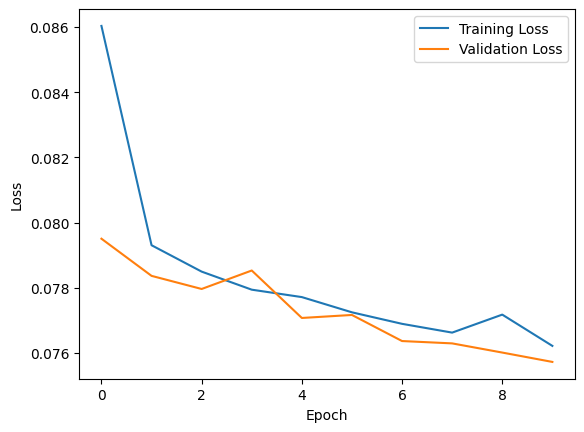

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint


pixelcnn.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy())


history = pixelcnn.fit(
    x_train, x_train,
    validation_data=(x_test, x_test),
    epochs=10,
    batch_size=64
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
def generate_samples(model, num_samples, img_shape):
    samples = np.zeros((num_samples, *img_shape))


    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            for k in range(img_shape[2]):

                probs = model.predict(samples, verbose=0)


                samples[:, i, j, k] = np.random.binomial(1, probs[:, i, j, k])

    return samples


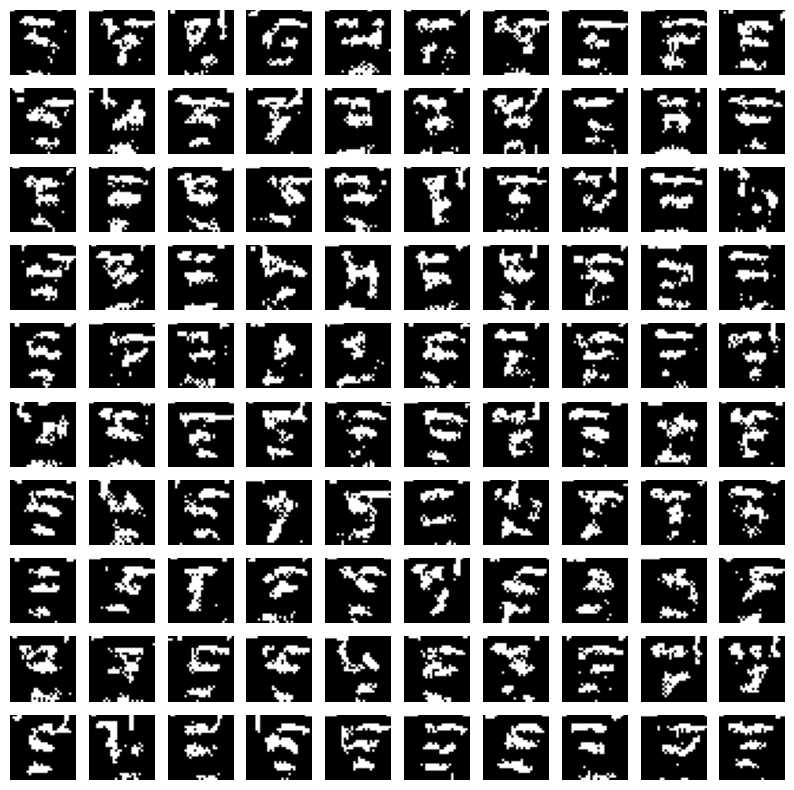

In [7]:
import matplotlib.pyplot as plt


generated_samples = generate_samples(pixelcnn, num_samples=100, img_shape=input_shape)


fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()
